In [1]:
!unzip /content/drive/MyDrive/PP-1/Implementation/Datasets/SisFall.zip

Archive:  /content/drive/MyDrive/PP-1/Implementation/Datasets/SisFall.zip
   creating: SisFall/
   creating: SisFall/ADL/
  inflating: SisFall/ADL/0_D01_SA01_R01.txt  
  inflating: SisFall/ADL/0_D01_SA02_R01.txt  
  inflating: SisFall/ADL/0_D01_SA03_R01.txt  
  inflating: SisFall/ADL/0_D01_SA04_R01.txt  
  inflating: SisFall/ADL/0_D01_SA05_R01.txt  
  inflating: SisFall/ADL/0_D01_SA06_R01.txt  
  inflating: SisFall/ADL/0_D01_SA07_R01.txt  
  inflating: SisFall/ADL/0_D01_SA08_R01.txt  
  inflating: SisFall/ADL/0_D01_SA09_R01.txt  
  inflating: SisFall/ADL/0_D01_SA10_R01.txt  
  inflating: SisFall/ADL/0_D01_SA11_R01.txt  
  inflating: SisFall/ADL/0_D01_SA12_R01.txt  
  inflating: SisFall/ADL/0_D01_SA13_R01.txt  
  inflating: SisFall/ADL/0_D01_SA14_R01.txt  
  inflating: SisFall/ADL/0_D01_SA15_R01.txt  
  inflating: SisFall/ADL/0_D01_SA16_R01.txt  
  inflating: SisFall/ADL/0_D01_SA17_R01.txt  
  inflating: SisFall/ADL/0_D01_SA18_R01.txt  
  inflating: SisFall/ADL/0_D01_SA19_R01.txt  
  in

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to preprocess a single file
def preprocess_file(file_path, label):
    # Load the data from the file
    data = np.loadtxt(file_path, delimiter=" ")  # Assuming space-separated values
    # Convert acceleration data from bits to gravity
    resolution = 13
    range_value = 16
    data = (2 * range_value / (2**resolution)) * data
    # Segment the data (adjust window_size and step_size as needed)
    window_size = 128  # You can adjust this window size
    step_size = 64     # You can adjust this step size
    segments = []
    labels = []
    for i in range(0, len(data) - window_size, step_size):
        segment = data[i:i+window_size]
        segments.append(segment)
        labels.append(label)
    return segments, labels

In [4]:
# Define a function to load and preprocess data from a folder
def load_and_preprocess_data(folder_path, label):
    segments = []
    labels = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            file_segments, file_labels = preprocess_file(file_path, label)
            segments.extend(file_segments)
            labels.extend(file_labels)
    return segments, labels

In [5]:
# Load and preprocess data from "ADL" and "FALL" folders
adl_folder = "/content/SisFall/ADL"
fall_folder = "/content/SisFall/FALL"
adl_segments, adl_labels = load_and_preprocess_data(adl_folder, 0)  # Label 0 for ADL
fall_segments, fall_labels = load_and_preprocess_data(fall_folder, 1)  # Label 1 for FALL

In [6]:
# Combine ADL and FALL data
X = np.array(adl_segments + fall_segments)
y = np.array(adl_labels + fall_labels)

In [7]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
print(f"ADL segments",len(adl_segments))
print(f"FALL segments",len(fall_segments))
print(f"ADL labels",len(adl_labels))
print(f"FALL labels",len(fall_labels))

ADL segments 6228
FALL segments 3596
ADL labels 6228
FALL labels 3596


In [9]:
print(f"ADL+FALL segments",len(X))
print(f"ADL+FALL labels",len(y))
print(f"Total",len(X)+len(y))

ADL+FALL segments 9824
ADL+FALL labels 9824
Total 19648


In [10]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7859, 128, 3)
(1965, 128, 3)
(7859,)
(1965,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, MaxPooling1D, BatchNormalization, Bidirectional, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           640       
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 256)           0

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# Model Compilation with initial learning rate
initial_learning_rate = 0.001
initial_batch_size = 64
initial_epochs = 20

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

# Initialize other hyperparameters
batch_size = initial_batch_size
epochs = initial_epochs

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model on the training data with early stopping and dynamic hyperparameter adjustment
for _ in range(5):  # You can adjust the number of iterations based on your needs
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr])

    # Check if validation accuracy decreased
    if history.history['val_accuracy'][-1] < max(history.history['val_accuracy']):
        # Adjust hyperparameters (batch size, epochs, etc.)
        batch_size = max(8, int(batch_size * 0.8))  # Decrease batch size by 20%, with a minimum value of 8
        epochs += 5  # Increase epochs by 5

        # Update the model with the new hyperparameters
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])
    else:
        break  # Break the loop if accuracy increased

# After the loop, you can use the final hyperparameters and the corresponding model

Epoch 1/20
123/123 [==============================] - 15s 28ms/step - loss: 0.6989 - accuracy: 0.6292 - val_loss: 0.6560 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 2/20
123/123 [==============================] - 1s 11ms/step - loss: 0.4978 - accuracy: 0.7666 - val_loss: 0.6241 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 3/20
123/123 [==============================] - 1s 11ms/step - loss: 0.4166 - accuracy: 0.8194 - val_loss: 0.4987 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 4/20
123/123 [==============================] - 1s 11ms/step - loss: 0.3638 - accuracy: 0.8511 - val_loss: 0.4943 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 5/20
123/123 [==============================] - 1s 11ms/step - loss: 0.3145 - accuracy: 0.8768 - val_loss: 0.4018 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 6/20
123/123 [==============================] - 1s 11ms/step - loss: 0.2962 - accuracy: 0.8854 - val_loss: 0.2882 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 7/20
123/123 [==============================] - 1s 11ms/s

In [14]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

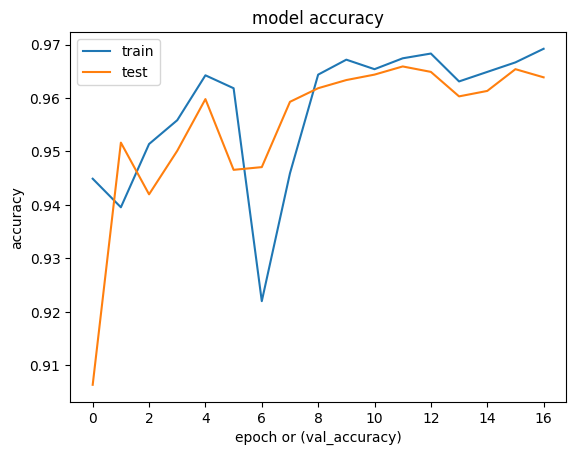

In [16]:
import matplotlib.pyplot as plt
#summarize model for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch or (val_accuracy)')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

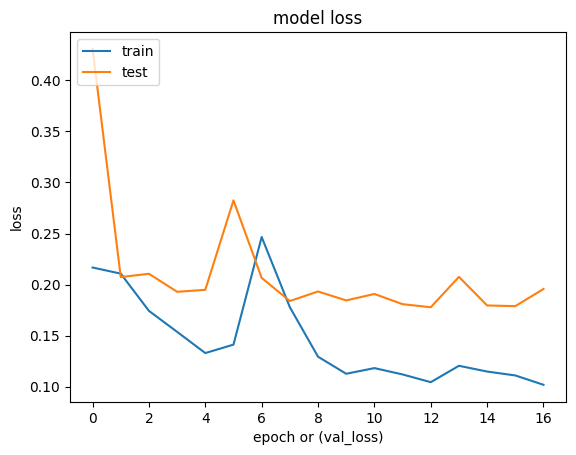

In [17]:
#summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch or (val_loss)')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

62/62 [==============================] - 2s 4ms/step - loss: 0.1808 - accuracy: 0.9659
Validation Accuracy: 96.59%


In [ ]:
# Save the model to a file
model.save("/content/drive/MyDrive/PP-1/Models/SisFall model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("/content/drive/MyDrive/PP-1/Models/SisFall model.h5")

# Prepare a single data sample (replace with your actual sensor data)
input_data1 = X_test[127]  # Replace with your sensor data in the right shape
input_data2 = X_test[155]  # Replace with your sensor data in the right shape

# Perform inference using the loaded model
prediction1 = loaded_model.predict(np.expand_dims(input_data1, axis=0))
prediction2 = loaded_model.predict(np.expand_dims(input_data2, axis=0))
# The prediction is a value between 0 and 1
if prediction1[0][0] >= 0.5:
    print("Fall detected")
else:
    print("No fall detected")
if prediction2[0][0] >= 0.5:
    print("Fall detected")
else:
    print("No fall detected")
print(prediction1[0][0])
print(prediction2[0][0])

1/1 [==============================] - 0s 23ms/step
Fall detected
No fall detected
1.0
1.2463493e-15
